0it [00:00, ?it/s]

0.4800320800206067


1it [1:04:15, 3855.21s/it]

-0.0020662384403762335


2it [2:14:10, 4055.19s/it]

-0.003114022377840253


3it [3:23:40, 4107.66s/it]

-0.002427419016302612


4it [4:32:53, 4125.65s/it]

0.0015299568829710841


7it [6:17:07, 3232.57s/it]


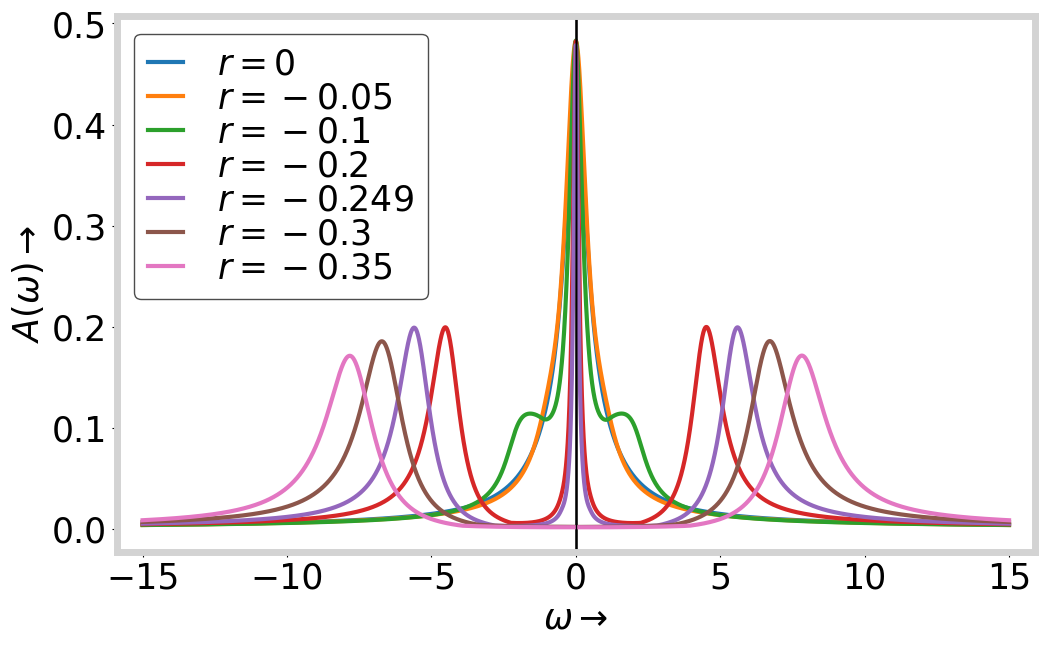

In [8]:
import numpy as np
import itertools
from scipy.signal import chirp, find_peaks, peak_widths
import matplotlib.pyplot as plt
from operator import itemgetter
from time import time
from tqdm import tqdm
from multiprocessing.pool import ThreadPool as Pool
import sys
import scipy.linalg
import scipy.sparse.linalg


#plt.style.use('bmh')
markers = ["o", "X", "P", "p", "*"]
cols = [p['color'] for p in plt.rcParams['axes.prop_cycle']]
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{braket}\usepackage{nicefrac}')
plt.rcParams.update({'font.size': 25,
                     'figure.figsize': (11,7),
                     'axes.facecolor': 'white',
                     'axes.edgecolor': 'lightgray',
                     "figure.autolayout": 'True',
                     'axes.xmargin': 0.03,
                     'axes.ymargin': 0.05,
                     'axes.grid': False,
                     'axes.linewidth': 5,
                     'lines.markersize': 10,
                     #'text.usetex': True,
                     'lines.linewidth': 8,
                     "legend.frameon": True,
                     "legend.framealpha": 0.7,
                     "legend.handletextpad": 1,
                     "legend.edgecolor": "black",
                     "legend.handlelength": 1,
                     "legend.labelspacing": 0,
                     "legend.columnspacing": 1,
                     "legend.fontsize": 30,
                    })
linestyles = ["-", "--", ":"]
bbox = dict(boxstyle="round", facecolor="lightgray")


#### RETURNS THE DENOMINATORS THAT APPEAR IN RG EQUATIONS ####

def getDenominators(omega, D, U, J, Ub):
    d0 = omega - D/2 + Ub/2 - U/2
    d1 = omega - D/2 + Ub/2 + U/2 + J/4
    d2 = omega - D/2 + Ub/2 + J/4
    return np.array([d0, d1, d2])



#### RETURNS THE MODIFIED SET OF COUPLINGS AT A GIVEN RG STEP ####

def rg_flow(omega, D0, DELTA_D, energyDOS, D, U, V, J, signs, Ub):
    denominators = getDenominators(omega, D, U, J, Ub)
    theta = 1 * (signs * denominators > 0)
    deltaU = energyDOS(D0, D) * DELTA_D * (4*V**2 * (theta[1]/denominators[1] - theta[0]/denominators[0]) - J**2 * theta[2] / denominators[2])
    deltaV = -energyDOS(D0, D) * DELTA_D * (3 * J * V / 8) * (theta[1]/denominators[1] + theta[2]/denominators[2])
    deltaJ = -energyDOS(D0, D) * DELTA_D * (J**2 + 4*J*Ub) * theta[2]/denominators[2]

    U = 0 if (U + deltaU) * U <= 0 else U + deltaU
    V = 0 if (V + deltaV) * V <= 0 else V + deltaV
    J = 0 if (J + deltaJ) * J <= 0 else J + deltaJ

    return U, V, J

#### TAKES BARE PARAMETER VALUES AND RETURNS THE COMPLETE RG FLOW ####

def complete_RG(D0, DELTA_D, energyDOS, U0, V0, J0, Ub):
    omega = -U0/4
    signs = np.sign(getDenominators(omega, D0, U0, J0, Ub))
    E, U, V, J = [[g0] for g0 in (D0, U0, V0, J0)]
    for D in np.arange(D0, 0, -DELTA_D):
        U_j, V_j, J_j = rg_flow(omega, D0, DELTA_D, energyDOS, D, U[-1], V[-1], J[-1], signs, Ub)
        U.append(U_j)
        V.append(V_j)
        J.append(J_j)
        E.append(D - DELTA_D)
        denominators = getDenominators(omega, E[-1], U[-1], J[-1], Ub)
        if True not in np.equal(np.sign(denominators), signs):
            break
        
    return np.flip(E), np.flip(U), np.flip(V), np.flip(J)



def getBasis(num_levels, nTot=-1):
    """ The argument num_levels is the total number of qubits
    participating in the Hilbert space. Function returns a basis
    of the classical states necessary to express any state as a 
    superposition. Members of the basis are lists such as 
    [0,0,0,0], [0,0,0,1],..., [1,1,01] and [1,1,1,1], where each
    character represents the configuration (empty or occupied) of
    each single-particle level
    """
    
    basis = []
    for char_arr in itertools.product(["0", "1"], repeat=num_levels):
        if nTot == -1 or sum([int(ch) for ch in char_arr]) == nTot:
            basis.append("".join(char_arr))
    
    return basis


def applyTermOnBasisState(bstate, int_kind, site_indices):
    """ Applies a simple operator on a basis state. A simple operator is of the form '+-',[0,1].
    The first string, passed through the argument int_kind, indicates the form of the operator.
    It can be any operator of any length composed of the characters +,-,n,h. The list [0,1], passed
    through the argument site_indices, defines the indices of the sites on which the operators will 
    be applied. The n^th character of the string will act on the n^th element of site_indices. The
    operator is simple in the sense that there is no summation of multiple operators involved here.
    """

    # check that the operator is composed only out of +,-,n,h
    assert False not in [k in ['+', '-', 'n', 'h'] for k in int_kind], "Interaction type not among +, - or n."

    # check that the number of operators in int_kind matches the number of sites in site_indices.
    assert len(int_kind) == len(site_indices), "Number of site indices in term does not match number of provided interaction types."

    # final_coeff stores any factors that might emerge from applying the operator.
    final_coeff = 1

    # loop over all characters in the operator string, along with the corresponding site indices.
    for op, index in zip(int_kind[::-1], site_indices[::-1]):

        # if the character is a number or a hole operator, just give the corresponding occupancy.
        if op == "n":
            final_coeff *= int(bstate[index])
        elif op == "h":
            final_coeff *= 1 - int(bstate[index])

        # if the character is a create or annihilate operator, check if their is room for that.
        # If not, set final_coeff to zero. If there is, flip the occupancy of the site.
        elif (op == "+" and int(bstate[index]) == 1) or (op == "-" and int(bstate[index]) == 0):
            final_coeff *= 0
        else:
            final_coeff *= (-1) ** sum([int(ch) for ch in bstate[:index]])
            bstate = bstate[:index] + str(1 - int(bstate[index])) + (bstate[index+1:] if index + 1 < len(bstate) else '')

    return bstate, final_coeff


def getOperator(manyBodyBasis, int_kind, site_indices):
    """ Constructs a matrix operator given a prescription.
    manyBodyBasis is the set of all possible classical states.
    int_kind is a string that defines the qubit operators taking
    part in the operator. For eg.,'+-' means 'c^dag c'. 
    site_indices is a list that defines the indices of the states
    on whom the operators act. For rg., [0,1] means the operator
    is c^dag_0 c_1.
    """
    
    assert isinstance(manyBodyBasis, list)
    assert False not in [isinstance(item, str) for item in manyBodyBasis]
    # check that the number of qubit operators in int_kind matches the number of provided indices.
    assert isinstance(int_kind, str)
    assert False not in [k in ['+', '-', 'n', 'h'] for k in int_kind], "Interaction type not among +, - or n."
    #print(site_indices, [isinstance(index, int) for index in site_indices])
    # check that each operator in int_kind is from the set {+,-,n,h}, since these are the only ones we handle right now.
    assert isinstance(site_indices, list)
    assert False not in [isinstance(index, int) for index in site_indices]
    assert len(int_kind) == len(site_indices), "Number of site indices in term does not match number of provided interaction types."

    # initialises a zero matrix
    operator = np.zeros([len(manyBodyBasis), len(manyBodyBasis)], dtype=np.longdouble)
    
    # Goes over all pairs of basis states |b1>, |b2> of the operator in order to obtain each matrix element <b2|O|b1>.
    for start_index, start_state in enumerate(manyBodyBasis):
        
        # get the action of 'int_kind' on the state b2
        end_state, mat_ele = applyTermOnBasisState(start_state, int_kind, site_indices)

        if end_state in manyBodyBasis:
            end_index = manyBodyBasis.index(end_state)
            operator[end_index][start_index] = mat_ele
    return operator


def fermionicHamiltonian(manyBodyBasis, terms_list):
    """ Creates a matrix Hamiltonian from the specification provided in terms_list. terms_list is a dictionary
    of the form {['+','-']: [[1.1, [0,1]], [0.9, [1,2]], [2, [3,1]]], ['n']: [[1, [0]], [0.5, [1]], [1.2, [2]], [2, [3]]]}.
    Each key represents a specific type of interaction, such as c^dag c or n. The value associated with that key 
    is a nested list, of the form [g,[i_1,i_2,...]], where the inner list represents the indices of the particles 
    to whom those interactions will be applied, while the float value g in the outer list represents the strength 
    of that term in the Hamiltonian. For eg., the first key-value pair represents the interaction 
    1.1c^dag_0 c_1 + 0.9c^dag_1 c_2 + ..., while the second pair represents 1n_0 + 0.5n_1 + ...
    """
    
    # initialise a zero matrix
    hamlt = np.zeros([len(manyBodyBasis), len(manyBodyBasis)])

    # loop over all keys of the dictionary, equivalent to looping over various terms of the Hamiltonian
    for int_kind, val in terms_list.items():

        couplings = [t1 for t1,t2 in val]
        site_indices_all = [t2 for t1,t2 in val]

        # for each int_kind, pass the indices of sites to the get_operator function to create the operator 
        # for each such term
        hamlt += sum([coupling * getOperator(manyBodyBasis, int_kind, site_indices) for coupling, site_indices in tqdm(zip(couplings, site_indices_all), total=len(couplings), disable = True, desc="Obtaining operators for " + int_kind + " .")])
    return np.array(hamlt)


def get_eSIAMHamiltonian(manyBodyBasis, num_bath_sites, couplings):
    """ Gives the string-based prescription to obtain a eSIAM Hamiltonian:
    H = sum_k Ek n_ksigma + hop_strength sum_ksigma c^dag_ksigma c_dsigma + hc 
        + imp_Ed sum_sigma n_dsigma + imp_U n_dup n_ddn + kondo J sum_12 vec S_d dot vec S_{12}
    The coupling argument is a list that contains all the Hamiltonian parameters.
    Other parameters are self-explanatory. 
    """

    Ek, hop_strength, imp_U, imp_Ed, kondo_J, zerothsite_U = couplings
    # ensure the number of terms in the kinetic energy is equal to the number of bath sites provided
    assert len(Ek) == num_bath_sites

    # adjust dispersion to make room for spin degeneracy: (Ek1, Ek2) --> (Ek1,  Ek1,  Ek2,  Ek2)
    #                                                      k1   k2            k1up  k1dn  k2up  k2dn
    Ek = np.repeat(Ek, 2)
    #print(Ek)
    
    # create kinetic energy term, by looping over all bath site indices 2,3,...,2*num_bath_sites+1,
    # where 0 and 1 are reserved for the impurity orbitals and must therefore be skipped.
    ham_KE = fermionicHamiltonian(manyBodyBasis, {'n': [[Ek[i - 2], [i]] for i in range(2, 2 * num_bath_sites + 2)]})

    # create the impurity-bath hopping terms, by looping over the up orbital indices i = 2, 4, 6, ..., 2*num_bath_sites,
    # and obtaining the corresponding down orbital index as i + 1. The four terms are c^dag_dup c_kup, h.c., c^dag_ddn c_kdn, h.c.
    ham_hop = (fermionicHamiltonian(manyBodyBasis, {'+-': [[hop_strength, [0, i]] for i in range(2, 2 * num_bath_sites + 2, 2)]}) 
               + fermionicHamiltonian(manyBodyBasis, {'+-': [[hop_strength, [i, 0]] for i in range(2, 2 * num_bath_sites + 2, 2)]})
               + fermionicHamiltonian(manyBodyBasis, {'+-': [[hop_strength, [1, i + 1]] for i in range(2, 2 * num_bath_sites + 2, 2)]})
               + fermionicHamiltonian(manyBodyBasis, {'+-': [[hop_strength, [i + 1, 1]] for i in range(2, 2 * num_bath_sites + 2, 2)]})
              )

    # create the impurity local terms for Ed, U
    ham_imp = (fermionicHamiltonian(manyBodyBasis, {'n': [[imp_Ed, [0]], [imp_Ed, [1]]]}) 
               + fermionicHamiltonian(manyBodyBasis, {'nn': [[imp_U, [0, 1]]]})
              )

    # create the sum_k Sdz Skz term, by writing it in terms of number operators. 
    # The first line is n_dup sum_k Skz = n_dup sum_ksigma (-1)^sigma n_ksigma, sigma=(0,1).
    # The second line is -n_ddn sum_k Skz = -n_ddn sum_ksigma (-1)^sigma n_ksigma, sigma=(0,1).
    zz_terms = (sum([], [[kondo_J, [0, 2 * k1, 2 * k2]] for k1, k2 in itertools.product(range(1, num_bath_sites + 1), repeat=2)]) 
                + sum([], [[-kondo_J, [0, 2 * k1 + 1, 2 * k2 + 1]] for k1, k2 in itertools.product(range(1, num_bath_sites + 1), repeat=2)])
                + sum([], [[-kondo_J, [1, 2 * k1, 2 * k2]] for k1, k2 in itertools.product(range(1, num_bath_sites + 1), repeat=2)])
                + sum([], [[kondo_J, [1, 2 * k1 + 1, 2 * k2 + 1]] for k1, k2 in itertools.product(range(1, num_bath_sites + 1), repeat=2)])
               )
    Ham_zz = 0.25 * fermionicHamiltonian(manyBodyBasis, {'n+-': zz_terms})
    Ham_plus_minus = 0.5 * (fermionicHamiltonian(manyBodyBasis, {'+-+-': [[kondo_J, [0, 1, 2 * k1 + 1, 2 * k2]] for k1,k2 in itertools.product(range(1, num_bath_sites + 1), repeat=2)]}))



    # Create the zerthsite Hamiltonian operator
    # The first part is the cross term c^dag_k1up c_k2up c^dag_k3down c_k4down
    # second part is zerothOccupUp term c^dag_k1up c_k2up 
    # third part is zerothOccupDown term c^dag_k1down c_k2down

    cross_term = (sum([],[[zerothsite_U, [2 * k1, 2 * k2, 2 * k3 +1, 2 * k4 + 1]] for k1, k2, k3, k4 in itertools.product(range(1, num_bath_sites + 1), repeat=4)])
                 )
    zerothOccupUp = (sum([],[[-0.5 * zerothsite_U, [2 * k1, 2 * k2]] for k1, k2 in itertools.product(range(1, num_bath_sites + 1), repeat=2)])
                 )

    zerothOccupDown = (sum([],[[-0.5 * zerothsite_U, [2 * k1 + 1, 2 * k2 + 1]] for k1, k2 in itertools.product(range(1, num_bath_sites + 1), repeat=2)])
                 )
    
    ham_zerothsite = (fermionicHamiltonian(manyBodyBasis, {'+-': zerothOccupUp})
                      + fermionicHamiltonian(manyBodyBasis, {'+-': zerothOccupDown})
                      + fermionicHamiltonian(manyBodyBasis, {'+-+-': cross_term})
                     )
                    
    return ham_KE + ham_hop + ham_imp + Ham_zz + Ham_plus_minus + np.conj(np.transpose(Ham_plus_minus)) + ham_zerothsite

def get_computational_coefficients(basis, state):
    """ Given a general state and a complete basis, returns specifically those
    basis states that can express this general state as a superposition. Also returns
    the associated coefficients of the superposition.
    """
    assert len(basis) == len(state)
    decomposition = dict()
    for i,coeff in enumerate(state):
        decomposition[basis[i]] = coeff
    
    return decomposition

def diagonalise(basis, hamlt):
    """ Diagonalise the provided Hamiltonian matrix.
    Returns all eigenvals and states.
    """
    
    E, v = scipy.linalg.eigh(hamlt)
    with Pool() as pool:
        workers = [pool.apply_async(get_computational_coefficients, (basis, v[:,i])) for i in range(len(E))]
        eigstates = [worker.get() for worker in tqdm(workers, disable= True, desc="Expressing state in terms of basis.")]
    return E, eigstates

def init_wavefunction(hamlt, mb_basis, displayGstate=False):
    """ Generates the initial wavefunction at the fixed point by diagonalising
    the Hamiltonian provided as argument. Expresses the state as a superposition
    of various classical states, returns these states and the associated coefficients.
    No IOMS are taken into account at this point.
    """
   
    eigvals, eigstates = diagonalise(mb_basis, hamlt)
    tolerance = 10
    #print ("G-state energy:", eigvals[eigvals == min(eigvals)])
    if sum (np.round(eigvals, tolerance) == min(np.round(eigvals, tolerance))) == 1:
        gstate = eigstates[0]
        excitedstate = eigstates[1:]
        E_0 = eigvals[0]
        E_n = eigvals[1:]
    else:
        #assert False, 
        "Ground state is degenerate! No SU(2)-symmetric ground state exists."
    
    if displayGstate:
        print (visualise_state(mb_basis, gstate))

    return eigvals, eigstates

def applyOperatorOnState(initialState, terms_list, finalState=dict(), tqdmDesc=None):
    """ Applies a general operator on a general state. The general operator is specified through
    the terms_list parameter. The description of this parameter has been provided in the docstring
    of the get_fermionic_hamiltonian function.
    """

    # loop over all basis states for the given state, to see how the operator acts 
    # on each such basis state
    for bstate, coeff in tqdm(initialState.items(), disable=True, desc=tqdmDesc):

        # loop over each term (for eg the list [[0.5,[0,1]], [0.4,[1,2]]]) in the full interaction,
        # so that we can apply each such chunk to each basis state.
        for int_kind, val in terms_list.items():

            # loop over the various coupling strengths and index sets in each interaction term. In
            # the above example, coupling takes the values 0.5 and 0.4, while site_indices take the values
            # [0,1] and [1,2].
            
            for coupling, site_indices in val:

                # apply each such operator chunk to each basis state
                mod_bstate, mod_coeff = applyTermOnBasisState(bstate, int_kind, site_indices)

                # multiply this result with the coupling strength and any coefficient associated 
                # with the initial state
                mod_coeff *= coeff * coupling

                if mod_coeff != 0:
                    try:
                        finalState[mod_bstate] += mod_coeff
                    except:
                        finalState[mod_bstate] = mod_coeff
                           
    return finalState

def innerProduct(state2, state1):
    """ Calculates the overlap <state2 | state1>.
    """
    innerProduct = sum([np.conjugate(state2[bstate]) * state1[bstate] for bstate in state1 if bstate in state2])
    return innerProduct

def matrixElement(finalState, operator, initState):
    """ Calculates the matrix element <final_state | operator | init_state> of an
    operator between the states initState and finalState  
    """
    intermediateState = applyOperatorOnState(initState, operator, finalState=dict())
    matElement = innerProduct(finalState, intermediateState)
    return matElement

def spectral_function_per_RG_step(args):
    E_k_spacing_i, U_i, V_i, J_i, D0, U0, V0, J0, Ub, num_entangled, hamiltonianFunc, bandwidth, a, b = args
    A_UP = 0
    A_DOWN = 0

    # get the basis of all classical states.
    mb_basis = getBasis(2 * (1 + num_entangled))
    Ek_i = np.linspace(-E_k_spacing_i, E_k_spacing_i, num_entangled)

    init_couplings = [Ek_i, V_i, U_i, -U_i/2, 0, Ub]
    
    # obtain the zero-bandwidth Hamiltonian at the IR
    hamlt = hamiltonianFunc(mb_basis, num_entangled, init_couplings)


    eigvals, eigstates = init_wavefunction(hamlt, mb_basis)

    lenEvli = 0
    lenEvlf = len(eigvals)
    
    
    tolerance = 8
    Degeneracy = sum (np.round(eigvals, tolerance) == min(np.round(eigvals, tolerance)))
    E_0 = eigvals[:Degeneracy]
    
    #E_n = [eigval for eigval in eigvals if eigval < 0][Degeneracy:]
    E_n = eigvals[lenEvli:lenEvlf]
    #print(Degeneracy)
    gstates = eigstates[:Degeneracy]
    #excitedstates = [eigstate for eigval, eigstate in zip(eigvals, eigstates) if eigval < 0][Degeneracy:]
    allstates = eigstates[lenEvli:lenEvlf]
    #print(eigvals)
    
    #a = 1.5
    #b = 0.03
    Brodening_eta = lambda w: (a + b * (abs(w) - U0/4)) if (abs(w) - U0/4) >0 else a
    
    operator = dict()
    operator['-'] = [[1, [0]]]
    #operator['+--'] = [[1, [1, 0, 2 * k + 1]] for k in range(1, num_entangled + 1)]
    #operator['n-'] = [[0.5, [0, 2 * k]] for k in range(1, num_entangled + 1)] + [[-0.5, [1, 2 * k]] for k in range(1, num_entangled + 1)]
    
    for i in range(0, Degeneracy):
        Coeffs1 = [(matrixElement(gstates[i], operator, allstates[n]) ** 2) for n in range(0,len(allstates))] 
        Coeffs2 = [(matrixElement(allstates[n], operator, gstates[i]) ** 2) for n in range(0,len(allstates))] 
        delta1 = lambda w: (1/( np.pi)) * (Brodening_eta(w)/((w + E_0[i] - E_n)**2 + Brodening_eta(w)**2))
        delta2 = lambda w: (1/( np.pi)) * (Brodening_eta(w)/((w - E_0[i] + E_n)**2 + Brodening_eta(w)**2))
        #print('H',[Coeff1 for Coeff1 in Coeffs1 if Coeff1 > 1e-10])
        #print('G',[E_n[n] - E_0[i] for n, Coeff1 in zip(range(0,len(excitedstates)),Coeffs1) if Coeff1 > 1e-10])
        
        A_UP +=  np.array([ (1/Degeneracy) * sum(Coeffs1 * delta1(w) + Coeffs2 * delta2(w)) for w in tqdm(bandwidth, disable = True)])
    
    
    
    if U_i > 0 and J_i > J0:
        init_couplings = [Ek_i, 0, 0, 0, J_i, Ub]

        # obtain the zero-bandwidth Hamiltonian at the IR
        hamlt = hamiltonianFunc(mb_basis, num_entangled, init_couplings)


        eigvals, eigstates = init_wavefunction(hamlt, mb_basis)

        lenEvli = 0
        lenEvlf = len(eigvals)
        
        
        tolerance = 8
        Degeneracy = sum (np.round(eigvals, tolerance) == min(np.round(eigvals, tolerance)))
        E_0 = eigvals[:Degeneracy]
        
        #E_n = [eigval for eigval in eigvals if eigval < 0][Degeneracy:]
        E_n = eigvals[lenEvli:lenEvlf]
        #print(Degeneracy)
        gstates = eigstates[:Degeneracy]
        #excitedstates = [eigstate for eigval, eigstate in zip(eigvals, eigstates) if eigval < 0][Degeneracy:]
        allstates = eigstates[lenEvli:lenEvlf]
        #print(eigvals)
        
        #a = 1.5
        #b = 0.03
        Brodening_eta = lambda w: (a + b * (abs(w) - U0/4)) if (abs(w) - U0/4) >0 else a
        
        operator = dict()
        operator['-'] = [[1, [0]]]
        #operator['+--'] = [[1, [1, 0, 2 * k + 1]] for k in range(1, num_entangled + 1)]
        #operator['n-'] = [[0.5, [0, 2 * k]] for k in range(1, num_entangled + 1)] + [[-0.5, [1, 2 * k]] for k in range(1, num_entangled + 1)]
        
        for i in range(0, Degeneracy):
            Coeffs1 = [(matrixElement(gstates[i], operator, allstates[n]) ** 2) for n in range(0,len(allstates))] 
            Coeffs2 = [(matrixElement(allstates[n], operator, gstates[i]) ** 2) for n in range(0,len(allstates))] 
            delta1 = lambda w: (1/( np.pi)) * (Brodening_eta(w)/((w + E_0[i] - E_n)**2 + Brodening_eta(w)**2))
            delta2 = lambda w: (1/( np.pi)) * (Brodening_eta(w)/((w - E_0[i] + E_n)**2 + Brodening_eta(w)**2))
            #print('H',[Coeff1 for Coeff1 in Coeffs1 if Coeff1 > 1e-10])
            #print('G',[E_n[n] - E_0[i] for n, Coeff1 in zip(range(0,len(excitedstates)),Coeffs1) if Coeff1 > 1e-10])
            
            A_UP +=  (1.5 * D0/U0)**2 * np.array([ (1/Degeneracy) * sum(Coeffs1 * delta1(w) + Coeffs2 * delta2(w)) for w in tqdm(bandwidth, disable = True)])
        
       
    A_per_RG = A_UP 
    A_per_RG_norm = A_per_RG / np.trapz(A_per_RG, bandwidth)   
     
    return A_per_RG_norm

def get_Spectral_function(D0, U0, V0, J0, Ub, num_entangled, hamiltonianFunc, bandwidth, a, b):
    
    deltaD = 0.001
    
    def flatDOS(D0, D):
        return 1/D0
        
    D, U, V, J = complete_RG(D0, deltaD, flatDOS, U0, V0, J0, Ub)
    #print(V[0])
    
    
    E_k_spacing = np.linspace(deltaD, max(bandwidth), len(D))
    
    
    A = 0
    Args_list = [[E_k_spacing_i, U_i, V_i, J_i, D0, U0, V0, J0, Ub, num_entangled, hamiltonianFunc, bandwidth, a, b] for E_k_spacing_i, U_i, V_i, J_i in zip(E_k_spacing, U, V, J)]
    A = sum([spectral_function_per_RG_step(Args) for Args in Args_list])                 
        
    A = A / np.trapz(A, bandwidth)   
    
    return A

def find_FDS_broadening(D0, U0, V0, J0, Ub, target_height, num_entangled, broad_init, eta_delta, bandPoints):
    broad = broad_init
    spec_func_norm = get_Spectral_function(D0, U0, V0, J0, Ub, num_entangled, get_eSIAMHamiltonian,bandwidth, broad, eta_delta)
    height_diff = target_height - spec_func_norm[int(bandPoints/2)]
    print(height_diff)
    height_diff_tolerance = 1e-2
    if abs(height_diff)/target_height < height_diff_tolerance:
        return broad
    broad_delta = - np.sign(height_diff) * broad_init/4
    with tqdm(total=0) as pbar:
        while abs(broad_delta) > 1e-7:
            broad += broad_delta
            print(broad, broad_delta)
            assert broad > 0 
            spec_func_norm = get_Spectral_function(D0, U0, V0, J0, Ub, num_entangled, get_eSIAMHamiltonian,bandwidth, broad, eta_delta)
            height_diff = target_height - spec_func_norm[int(bandPoints/2)]
            print(height_diff)
            pbar.set_description("U={:.2f},broad={:.5f},inc={:.5f},distance={:.2f}%".format(U0,broad,broad_delta,100*(height_diff)/target_height))
            pbar.update(1)
            if abs(height_diff)/target_height < height_diff_tolerance:
                break
            if height_diff * broad_delta > 0:
                broad -= broad_delta
                broad_delta *= -0.5
            if broad + broad_delta <= 0:
                broad_delta *= 0.1
    if abs(height_diff)/target_height >= height_diff_tolerance:
        broad = -1
    return broad


def get_Spectral_function_plot(rs, bandwidth, bandPoints):
    num_entangled = 2
    
    A = [] 
    target_height = 1
    broad_init = [0.5,0.45630, 0.29475, 0.12617, 0.09097, 0.2, 0.2]
    eta_delta = 0.2
    for r_i,broad_init_i in tqdm(zip(rs,broad_init)):
        D0 = 3
        J0 = 0.3
        Ub = r_i * J0
        U0 = -150 * Ub
        V0 = 0.3
        
        if U0 == 0 and Ub == 0:
            target_height = get_Spectral_function(D0, U0, V0, J0, Ub, num_entangled, get_eSIAMHamiltonian,bandwidth, broad_init_i, eta_delta)[int(bandPoints/2)]
            print(target_height)
            broad = broad_init_i
        elif 0 >Ub > (-0.25 * J0):
            broad = find_FDS_broadening(D0, U0, V0, J0, Ub, target_height, num_entangled, broad_init_i, eta_delta, bandPoints)
        else :
            broad = broad_init_i
        A.append(get_Spectral_function(D0, U0, V0, J0, Ub, num_entangled, get_eSIAMHamiltonian,bandwidth,broad, eta_delta))
    plt.show()
    i = 0

    for A_i in A:
        plt.plot(bandwidth, A_i, label = r'$r = {B}$'.format(B = rs[i]), lw = 3 )
        plt.xlabel(r"$\omega \rightarrow$")
        plt.ylabel(r"$A(\omega)\rightarrow$")
        plt.axvline(x=0, c= 'k', lw=1)
        plt.legend( loc ="upper left", fontsize="25")
        # plt.yscale("log")
        i +=1
    plt.savefig("eSIAM_Spectral_Function.pdf" , bbox_inches='tight')
    plt.show()
    return 
                 
rs = [0, -0.05, -0.1, -0.2, -0.249, -0.3, -0.35]
bandPoints = 5001
bandwidth = np.linspace(-15, 15, bandPoints)
get_Spectral_function_plot(rs, bandwidth, bandPoints)